In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

from classes.cube_classes import Cube3State, Cube3
from generate.generate_states import ids_to_color
from utils.random_seed import seed_worker, seed_all, init_weights

torch.set_default_dtype(torch.float64)

import seaborn as sns
import matplotlib.pyplot as plt
import os

In [81]:
DATASET = '6moves'
# models = ['SymEqNet_100_500', 'SymEqNet_1000_1000', 'ResNet']
models = ['SymEqNet_1000_1000', 'ResNet']
# models = ['SymEqNet', 'ResNet']

In [82]:
RESULT_FOLDERS = {
    model: f'results/{DATASET}/{model}' for model in models
}

In [83]:
test_sizes = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
configs = [(rnd_seed, test_size) for rnd_seed in range(0, 10) for test_size in test_sizes]

In [84]:
last_train_losses_dict, last_test_losses_dict, mean_train_losses_dict, mean_test_losses_dict, results_train_dict, results_test_dict = \
    {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}

for model in models:
    for i, config in enumerate(configs):
        if os.path.isfile(RESULT_FOLDERS[model] + f'/last_train_losses_rs{config[0]}_ts{config[1]}.npy'):
            last_train_losses = np.load(RESULT_FOLDERS[model] + f'/last_train_losses_rs{config[0]}_ts{config[1]}.npy')
            last_test_losses = np.load(RESULT_FOLDERS[model] + f'/last_test_losses_rs{config[0]}_ts{config[1]}.npy')
            mean_train_losses = np.load(RESULT_FOLDERS[model] + f'/mean_train_losses_rs{config[0]}_ts{config[1]}.npy')
            mean_test_losses = np.load(RESULT_FOLDERS[model] + f'/mean_test_losses_rs{config[0]}_ts{config[1]}.npy')
            results = np.load(RESULT_FOLDERS[model] + f'/results_rs{config[0]}_ts{config[1]}.npy')
        else:
            last_train_losses = []
            last_test_losses = []
            mean_train_losses = np.zeros(1000)
            mean_test_losses = np.zeros(1000)
            results = [0, 0]

        last_train_losses_dict[model][config[1]].append(last_train_losses)
        last_test_losses_dict[model][config[1]].append(last_test_losses)
        mean_train_losses_dict[model][config[1]].append(mean_train_losses)
        mean_test_losses_dict[model][config[1]].append(mean_test_losses)
        results_train_dict[model][config[1]].append(results[0])
        results_test_dict[model][config[1]].append(results[1])

In [85]:
for model in models:
    print(f'MODEL {model}')
    for key in results_test_dict[model]:
        mean = np.mean(results_test_dict[model][key])
        std = np.std(results_test_dict[model][key])
        print(f'Test Size {int(key*100)}%: MAE {mean:.4f} +- {std:.4f}')
    print('')

MODEL SymEqNet_1000_1000
Test Size 10%: MAE 0.1469 +- 0.0248
Test Size 20%: MAE 0.2434 +- 0.0739
Test Size 30%: MAE 0.2299 +- 0.0415
Test Size 40%: MAE 0.2399 +- 0.0594
Test Size 50%: MAE 0.2544 +- 0.1604
Test Size 60%: MAE 0.2060 +- 0.0396
Test Size 70%: MAE 0.2426 +- 0.0675
Test Size 80%: MAE 0.2118 +- 0.0309
Test Size 90%: MAE 0.2451 +- 0.0228

MODEL ResNet
Test Size 10%: MAE 0.0644 +- 0.0149
Test Size 20%: MAE 0.0762 +- 0.0180
Test Size 30%: MAE 0.0731 +- 0.0119
Test Size 40%: MAE 0.0800 +- 0.0216
Test Size 50%: MAE 0.0938 +- 0.0126
Test Size 60%: MAE 0.1322 +- 0.0147
Test Size 70%: MAE 0.1762 +- 0.0250
Test Size 80%: MAE 0.1972 +- 0.0191
Test Size 90%: MAE 0.2549 +- 0.0339



In [86]:
model_ls, random_seed_ls, test_size_ls, train_loss_ls, test_loss_ls, epochs = [], [], [], [], [], []
# for model in ['SymEqNet', 'ResNet']:
for model in models:
    for rs, ts in configs:
        for epoch in range(10):
            model_ls.append(model)
            random_seed_ls.append(rs)
            test_size_ls.append(ts)
            train_loss_ls.append(mean_train_losses_dict[model][ts][rs][epoch])
            test_loss_ls.append(mean_test_losses_dict[model][ts][rs][epoch])
            epochs.append(epoch+1)

In [87]:
df = pd.DataFrame({'model': model_ls, 'random_seed': random_seed_ls, 'test_size': test_size_ls, 'train_loss': train_loss_ls, 'test_loss': test_loss_ls, 'epoch': epochs})
df.head()

,model,random_seed,test_size,train_loss,test_loss,epoch
0,SymEqNet_1000_1000,0,0.1,0.210614,0.186036,1
1,SymEqNet_1000_1000,0,0.1,0.120641,0.146207,2
2,SymEqNet_1000_1000,0,0.1,0.088887,0.174713,3
3,SymEqNet_1000_1000,0,0.1,0.082556,0.153497,4
4,SymEqNet_1000_1000,0,0.1,0.081775,0.134324,5


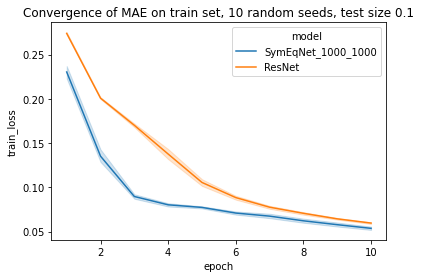

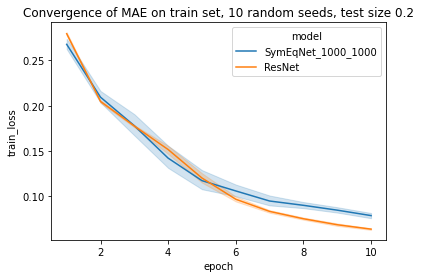

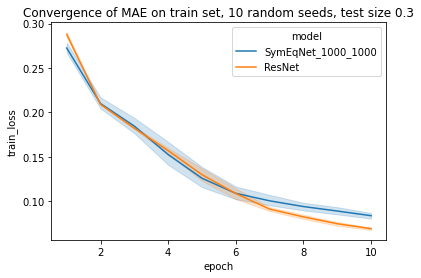

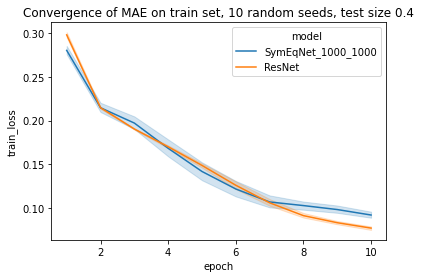

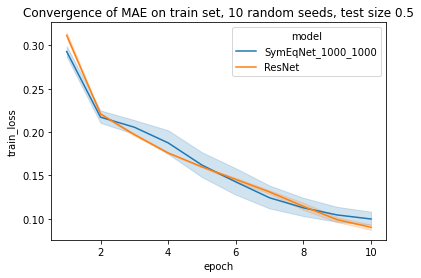

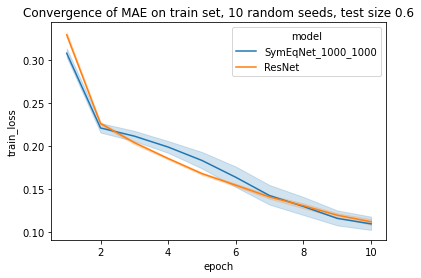

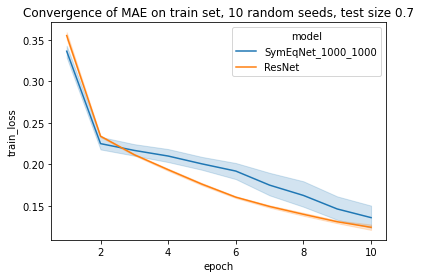

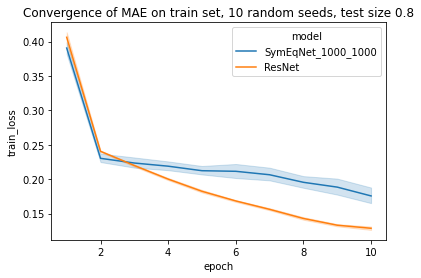

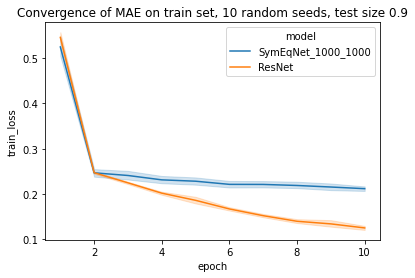

<Figure size 432x288 with 0 Axes>

In [88]:
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)] # & (df['epoch'] % 10 == 0)]
    sns.lineplot(data=df_test_size, x="epoch", y="train_loss", hue="model")
    plt.title(f'Convergence of MAE on train set, 10 random seeds, test size {test_size}')
    plt.savefig(f'imgs/convergence/{DATASET}/train_conv_testsize_{test_size}.png', dpi=100)
    plt.show()
    plt.cla()
    plt.clf()

model             ResNet
random_seed            9
test_size            0.1
train_loss     0.0613585
test_loss      0.0620756
epoch                 10
Name: 1719, dtype: object


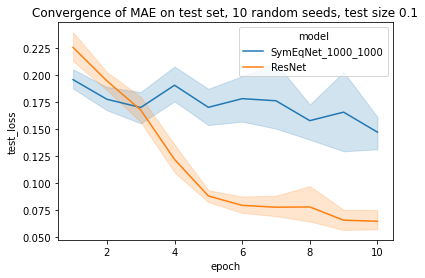

model             ResNet
random_seed            9
test_size            0.2
train_loss     0.0626765
test_loss       0.118625
epoch                 10
Name: 1729, dtype: object


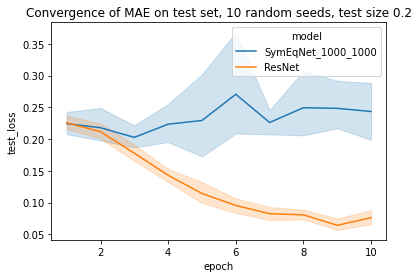

model             ResNet
random_seed            9
test_size            0.3
train_loss     0.0726966
test_loss      0.0939315
epoch                 10
Name: 1739, dtype: object


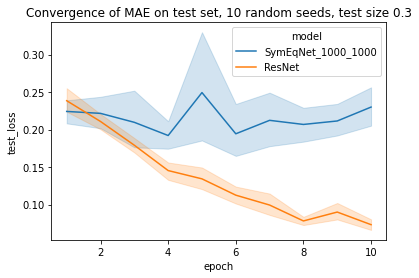

model             ResNet
random_seed            9
test_size            0.4
train_loss      0.078824
test_loss      0.0657013
epoch                 10
Name: 1749, dtype: object


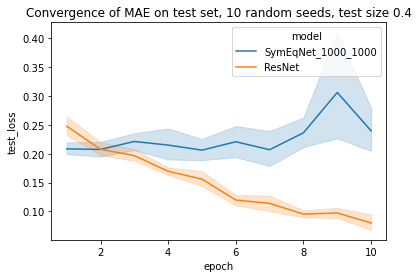

model             ResNet
random_seed            9
test_size            0.5
train_loss     0.0943137
test_loss      0.0865364
epoch                 10
Name: 1759, dtype: object


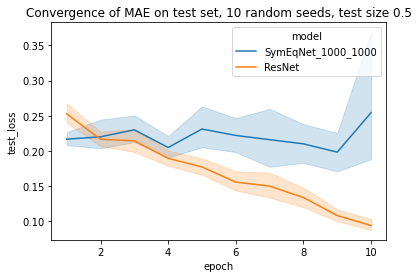

model            ResNet
random_seed           9
test_size           0.6
train_loss     0.111586
test_loss       0.12221
epoch                10
Name: 1769, dtype: object


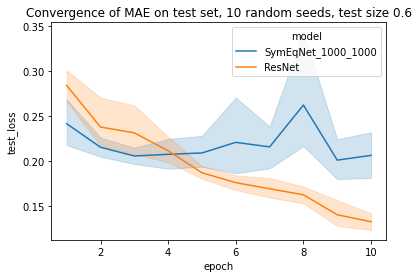

model            ResNet
random_seed           9
test_size           0.7
train_loss      0.12309
test_loss      0.171749
epoch                10
Name: 1779, dtype: object


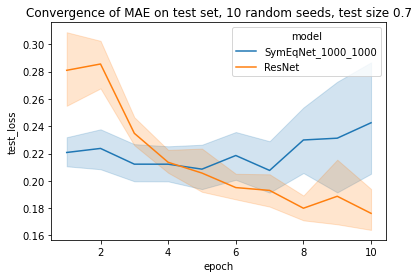

model            ResNet
random_seed           9
test_size           0.8
train_loss     0.126852
test_loss      0.210582
epoch                10
Name: 1789, dtype: object


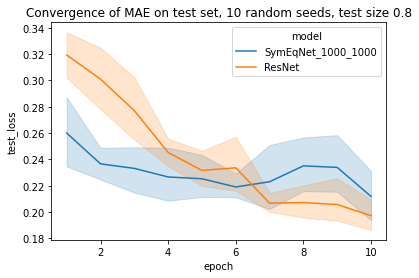

model            ResNet
random_seed           9
test_size           0.9
train_loss     0.130297
test_loss      0.214715
epoch                10
Name: 1799, dtype: object


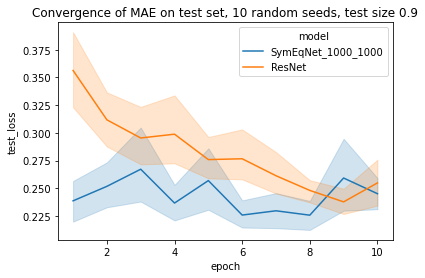

<Figure size 432x288 with 0 Axes>

In [89]:
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)] # & (df['epoch'] % 10 == 0)]
    print(df_test_size.iloc[-1])
    sns.lineplot(data=df_test_size, x="epoch", y="test_loss", hue="model")
    plt.title(f'Convergence of MAE on test set, 10 random seeds, test size {test_size}')
    plt.savefig(f'imgs/convergence/{DATASET}/test_conv_testsize_{test_size}.png', dpi=100)
    plt.show()
    plt.cla()
    plt.clf()

model             ResNet
random_seed            9
test_size            0.1
train_loss     0.0613585
test_loss      0.0620756
epoch                 10
Name: 1719, dtype: object


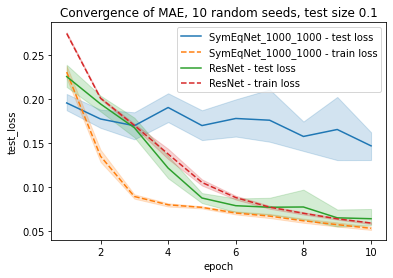

model             ResNet
random_seed            9
test_size            0.2
train_loss     0.0626765
test_loss       0.118625
epoch                 10
Name: 1729, dtype: object


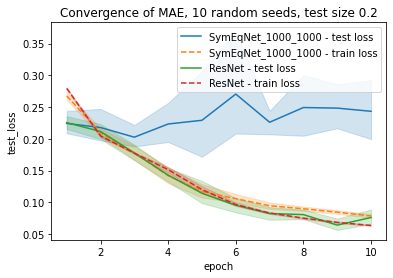

model             ResNet
random_seed            9
test_size            0.3
train_loss     0.0726966
test_loss      0.0939315
epoch                 10
Name: 1739, dtype: object


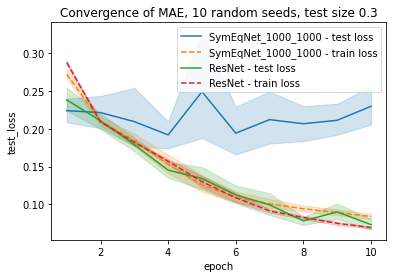

model             ResNet
random_seed            9
test_size            0.4
train_loss      0.078824
test_loss      0.0657013
epoch                 10
Name: 1749, dtype: object


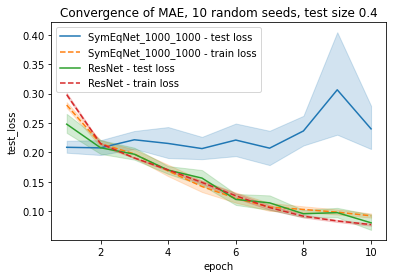

model             ResNet
random_seed            9
test_size            0.5
train_loss     0.0943137
test_loss      0.0865364
epoch                 10
Name: 1759, dtype: object


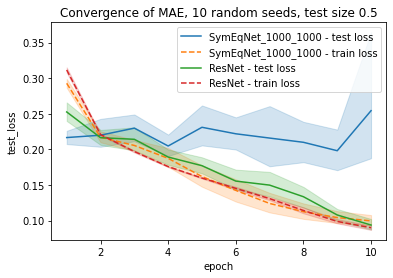

model            ResNet
random_seed           9
test_size           0.6
train_loss     0.111586
test_loss       0.12221
epoch                10
Name: 1769, dtype: object


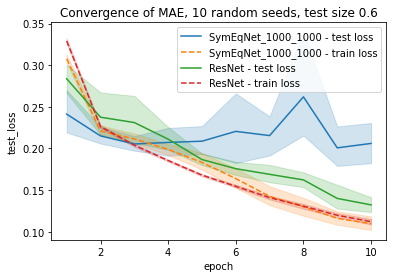

model            ResNet
random_seed           9
test_size           0.7
train_loss      0.12309
test_loss      0.171749
epoch                10
Name: 1779, dtype: object


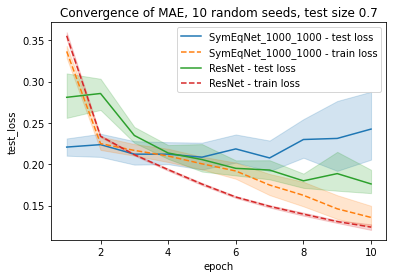

model            ResNet
random_seed           9
test_size           0.8
train_loss     0.126852
test_loss      0.210582
epoch                10
Name: 1789, dtype: object


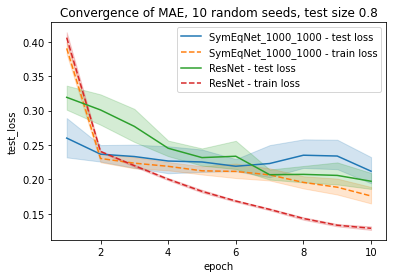

model            ResNet
random_seed           9
test_size           0.9
train_loss     0.130297
test_loss      0.214715
epoch                10
Name: 1799, dtype: object


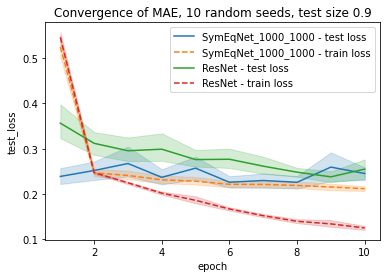

<Figure size 432x288 with 0 Axes>

In [90]:
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)] # & (df['epoch'] % 10 == 0)]
    print(df_test_size.iloc[-1])
    for model in models:
        sns.lineplot(data=df_test_size[df_test_size['model'] == model], x="epoch", y="test_loss", label=f"{model} - test loss")
        sns.lineplot(data=df_test_size[df_test_size['model'] == model], x="epoch", y="train_loss", label=f"{model} - train loss", linestyle='--')
    plt.title(f'Convergence of MAE, 10 random seeds, test size {test_size}')
    plt.savefig(f'imgs/convergence/{DATASET}/train_test_conv_testsize_{test_size}.png', dpi=100)
    plt.show()
    plt.cla()
    plt.clf()

In [91]:
model_ls, means, test_size_ls = [], [], []

# for model in ['SymEqNet', 'ResNet']:
for model in models:
    for rs, ts in configs:
        mean = results_test_dict[model][ts]
#         print(model, mean)
#         print(len(mean))
        model_ls += [model] * len(mean)
        test_size_ls += [ts] * len(mean)
        means += mean
final_maes_df = pd.DataFrame({'final_test_mean': means, 'model': model_ls, 'test_size': test_size_ls})

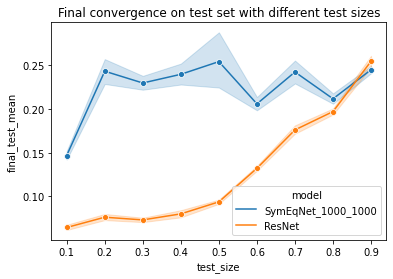

<Figure size 432x288 with 0 Axes>

In [92]:
sns.lineplot(data=final_maes_df, markers=True, x="test_size", y="final_test_mean", hue="model", marker="o")
plt.title(f'Final convergence on test set with different test sizes')
plt.savefig(f'imgs/convergence/{DATASET}/test_conv_per_testsize.png', dpi=100)
plt.show()
plt.cla()
plt.clf()